#  Analysis BitCoin Data Using ARIMA Models


Import the required library

In [133]:
import os
import sys

from pandas import read_csv
from pandas import datetime

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Create a function to plot the data

In [98]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

Simulate an ARIMA(2,1,1) model with alphas=[0.5,-0.25] and betas=[-0.5]

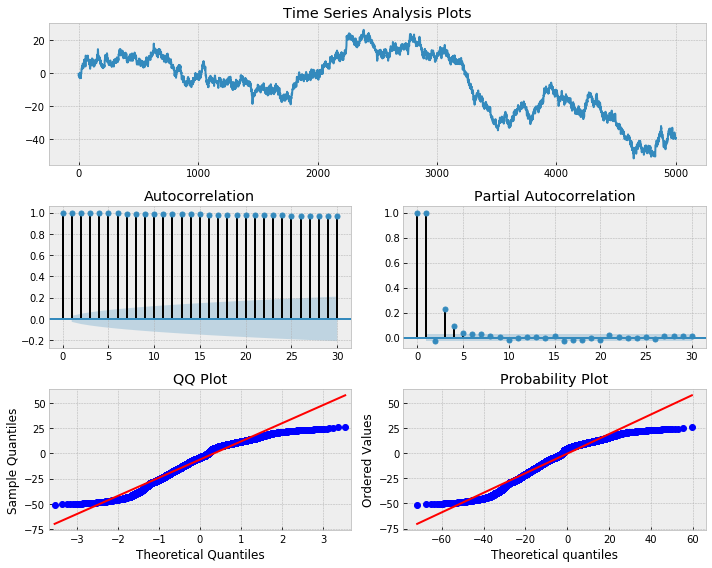

In [134]:
max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5,-0.25])
betas = np.array([-0.5])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma11 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
arima111 = arma11.cumsum()
_ = tsplot(arima111, lags=max_lag)

Fit ARIMA(p, d, q) model

Pick best order and final model based on AIC

aic: 14162.03258 | order: (2, 1, 1)


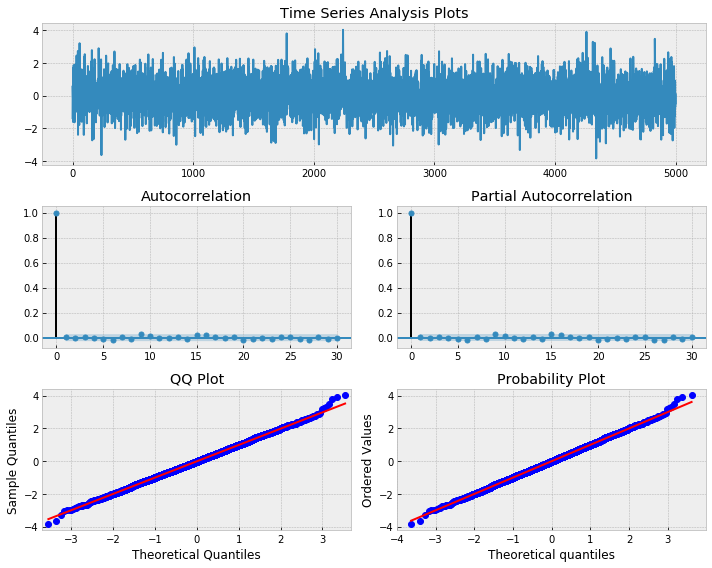

In [135]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(arima111, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In [6]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([22.20135811]), array([0.32968514]))

In [7]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.') 
print (pvalue)

The residuals seem normally distributed.
0.6657800370839815


After we make sure the simulation works properly, I will apply ARIMA on Bitcoin Hourly data 

In [101]:
def parser(x):
	return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")
series = read_csv('gemini_BTCUSD_1hr.csv', header=1, parse_dates=[1],
                  index_col=1,squeeze=True, date_parser=parser)

cols = ['Symbol', 'Unix Timestamp',
        'Open', 'High', 'Low', 'Volume']
series.drop(cols, axis=1, inplace=True)
series = series.sort_values('Date')
series.isnull().sum()


data = series

#log returns

lrets = np.log(data/data.shift(1))
lrets.dropna()

,Close
Date,
2015-10-08 14:00:00,0.000000
2015-10-08 15:00:00,-0.000327
2015-10-08 16:00:00,-0.002739
2015-10-08 17:00:00,0.003025
2015-10-08 18:00:00,-0.004049
2015-10-08 19:00:00,0.000000
2015-10-08 20:00:00,0.000000
2015-10-08 21:00:00,-0.000205
2015-10-08 22:00:00,0.000000


I will not include the data before 2016 becuase it doesn't have any seasonality or irregularity

I will set the training set between 2017 to 13 March 2019

In [103]:
lenseries = len(series)

start, end = pd.to_datetime(["2017-01-01 00:00:00", "2019-03-14 14:00:00"], 
                            format='%Y-%m-%d %H:%M:%S')
#(series >= start) & (series <= end)
trainingset = series[start : end]
trainingset

,Close
Date,
2017-01-01 00:00:00,972.000
2017-01-01 01:00:00,970.550
2017-01-01 02:00:00,969.890
2017-01-01 03:00:00,967.800
2017-01-01 04:00:00,967.800
2017-01-01 05:00:00,966.560
2017-01-01 06:00:00,967.800
2017-01-01 07:00:00,967.800
2017-01-01 08:00:00,967.800


In [104]:
# log returns
lretsTrain = np.log(trainingset/trainingset.shift(1))
lretsTrain.dropna()

,Close
Date,
2017-01-01 01:00:00,-0.001493
2017-01-01 02:00:00,-0.000680
2017-01-01 03:00:00,-0.002157
2017-01-01 04:00:00,0.000000
2017-01-01 05:00:00,-0.001282
2017-01-01 06:00:00,0.001282
2017-01-01 07:00:00,0.000000
2017-01-01 08:00:00,0.000000
2017-01-01 09:00:00,0.001765


Test data is between (2019-03-14) and (2019-03-21) in order to match the data from twitter

In [105]:
start_t, end_t = pd.to_datetime(["2019-03-14 14:00:00", "2019-03-26 00:00:00"], 
                            format='%Y-%m-%d %H:%M:%S')
testset = series[start_t : end_t] 
testset

,Close
Date,
2019-03-14 14:00:00,3852.22
2019-03-14 15:00:00,3855.95
2019-03-14 16:00:00,3849.07
2019-03-14 17:00:00,3856.90
2019-03-14 18:00:00,3851.74
2019-03-14 19:00:00,3850.97
2019-03-14 20:00:00,3852.00
2019-03-14 21:00:00,3856.74
2019-03-14 22:00:00,3854.92


Fit ARIMA(p, d, q) model to BTC log returns

pick best order and final model based on AIC

C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -122389.75477 | order: (3, 0, 3)


C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
C:\Users\ghait\Anaconda2\lib\site-packages\statsmodels\tsa\tsatools.py:650: Ru

<IPython.core.display.Javascript object>


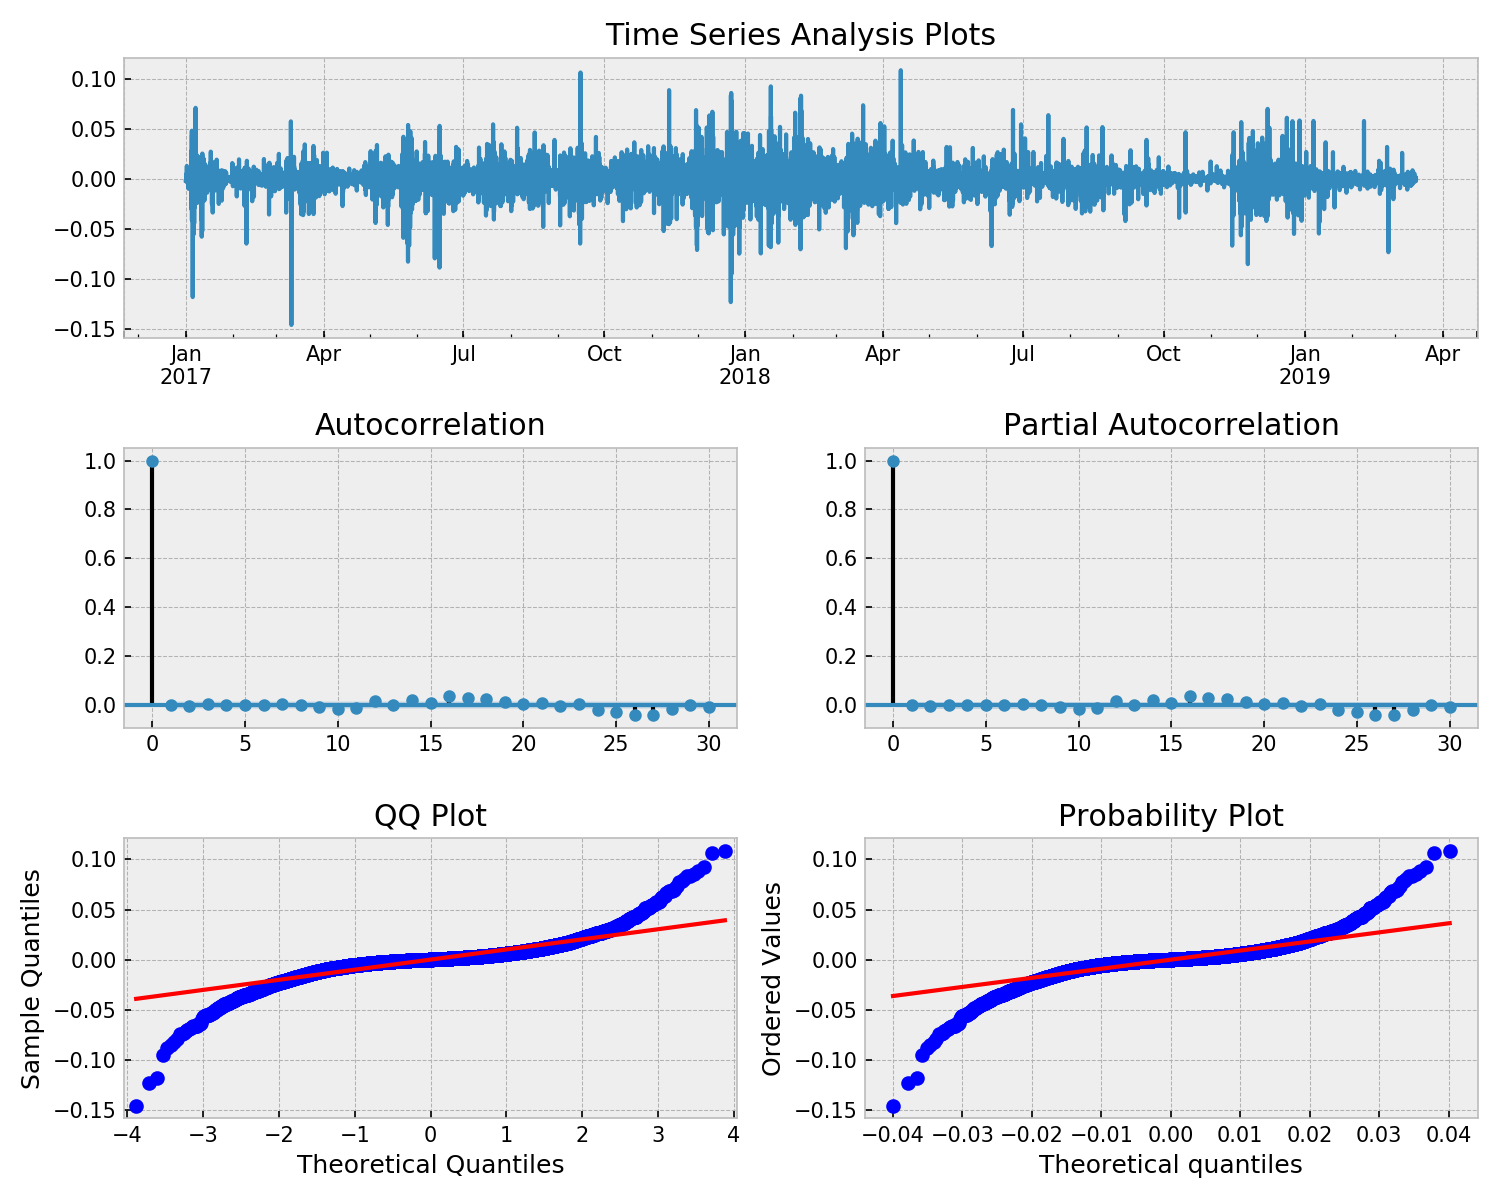

In [106]:
TS = lretsTrain['Close'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(1,5) # [1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

<IPython.core.display.Javascript object>


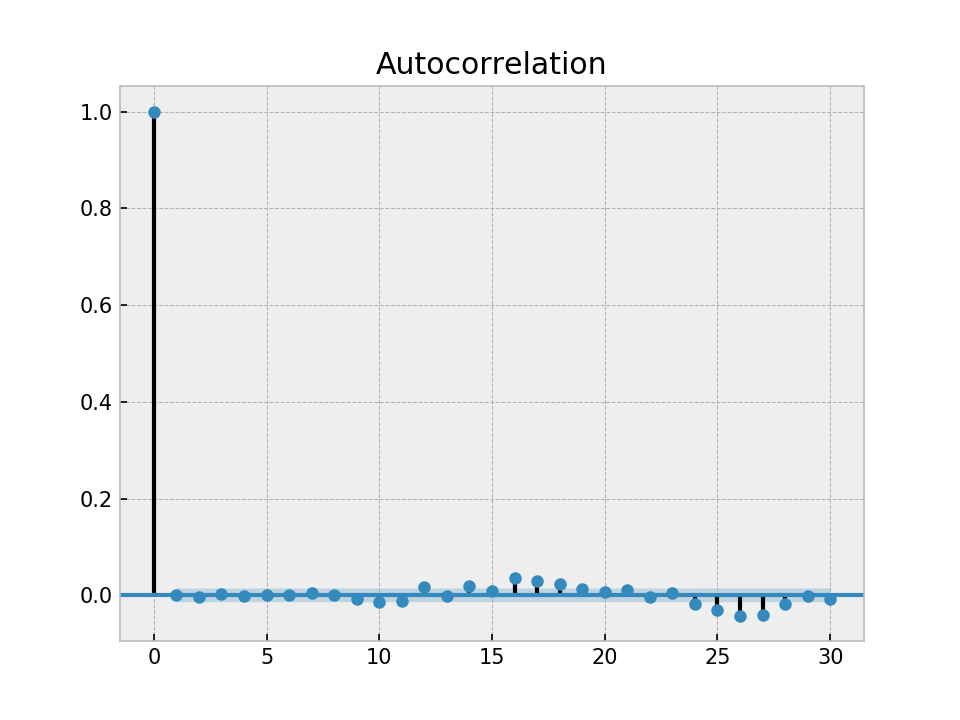

<IPython.core.display.Javascript object>


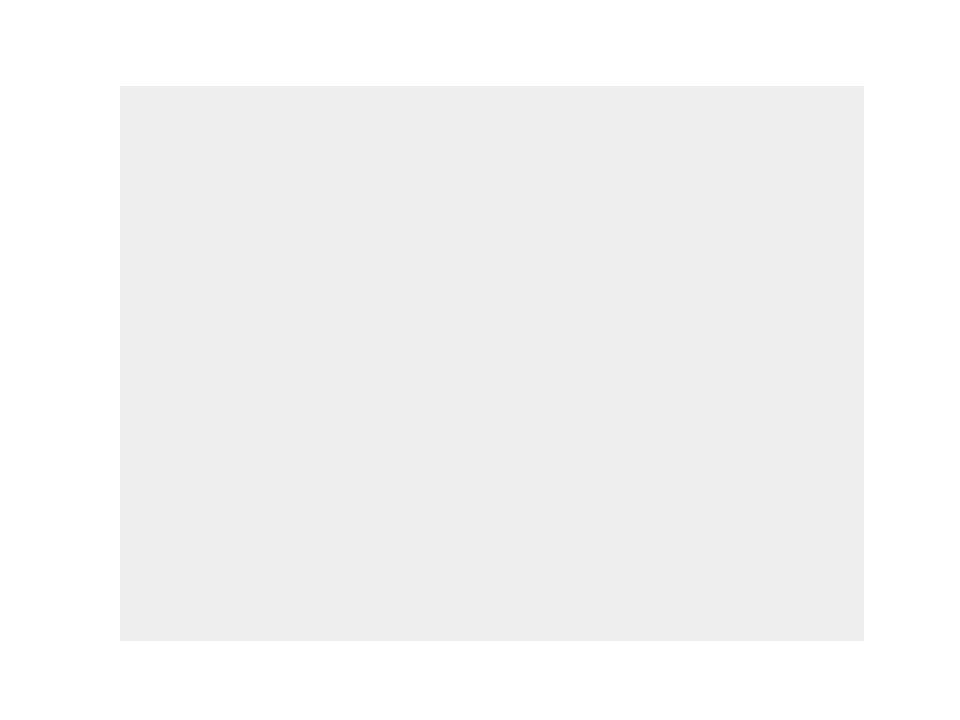

In [107]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(best_mdl.resid, lags = 30)

In [108]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([80.62429415]), array([3.07509347e-09]))

In [109]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

print(pvalue)

# https://stats.stackexchange.com/questions/79400/does-arima-require-normally-distributed-errors-or-normally-distributed-input-dat
#explanation of not normal distribution 

We have reason to suspect the residuals are not normally distributed.
0.0


#### Forecasting

We use statmodels forecast() method - we need to provide the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01. 

In [126]:
# Create a 24 hours forecast of Bitcoin returns with 95%, 99% CI
n_steps = 24

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(lretsTrain.index[-1], periods=n_steps, freq='H')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast log return', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all

,forecast log return,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2019-03-14 14:00:00,-0.000077,-0.019852,-0.026066,0.019697,0.025911
2019-03-14 15:00:00,-0.000078,-0.019873,-0.026092,0.019716,0.025936
2019-03-14 16:00:00,0.000034,-0.019774,-0.025998,0.019842,0.026066
2019-03-14 17:00:00,0.000007,-0.019801,-0.026025,0.019815,0.026039
2019-03-14 18:00:00,-0.000055,-0.019863,-0.026087,0.019753,0.025978
2019-03-14 19:00:00,0.000023,-0.019788,-0.026013,0.019833,0.026058
2019-03-14 20:00:00,0.000031,-0.019780,-0.026005,0.019841,0.026066
2019-03-14 21:00:00,-0.000044,-0.019856,-0.026081,0.019768,0.025993
2019-03-14 22:00:00,0.000001,-0.019811,-0.026037,0.019814,0.026039
2019-03-14 23:00:00,0.000039,-0.019774,-0.025999,0.019852,0.026078


Plot 6 hours forecast for bitcoin returns

<IPython.core.display.Javascript object>


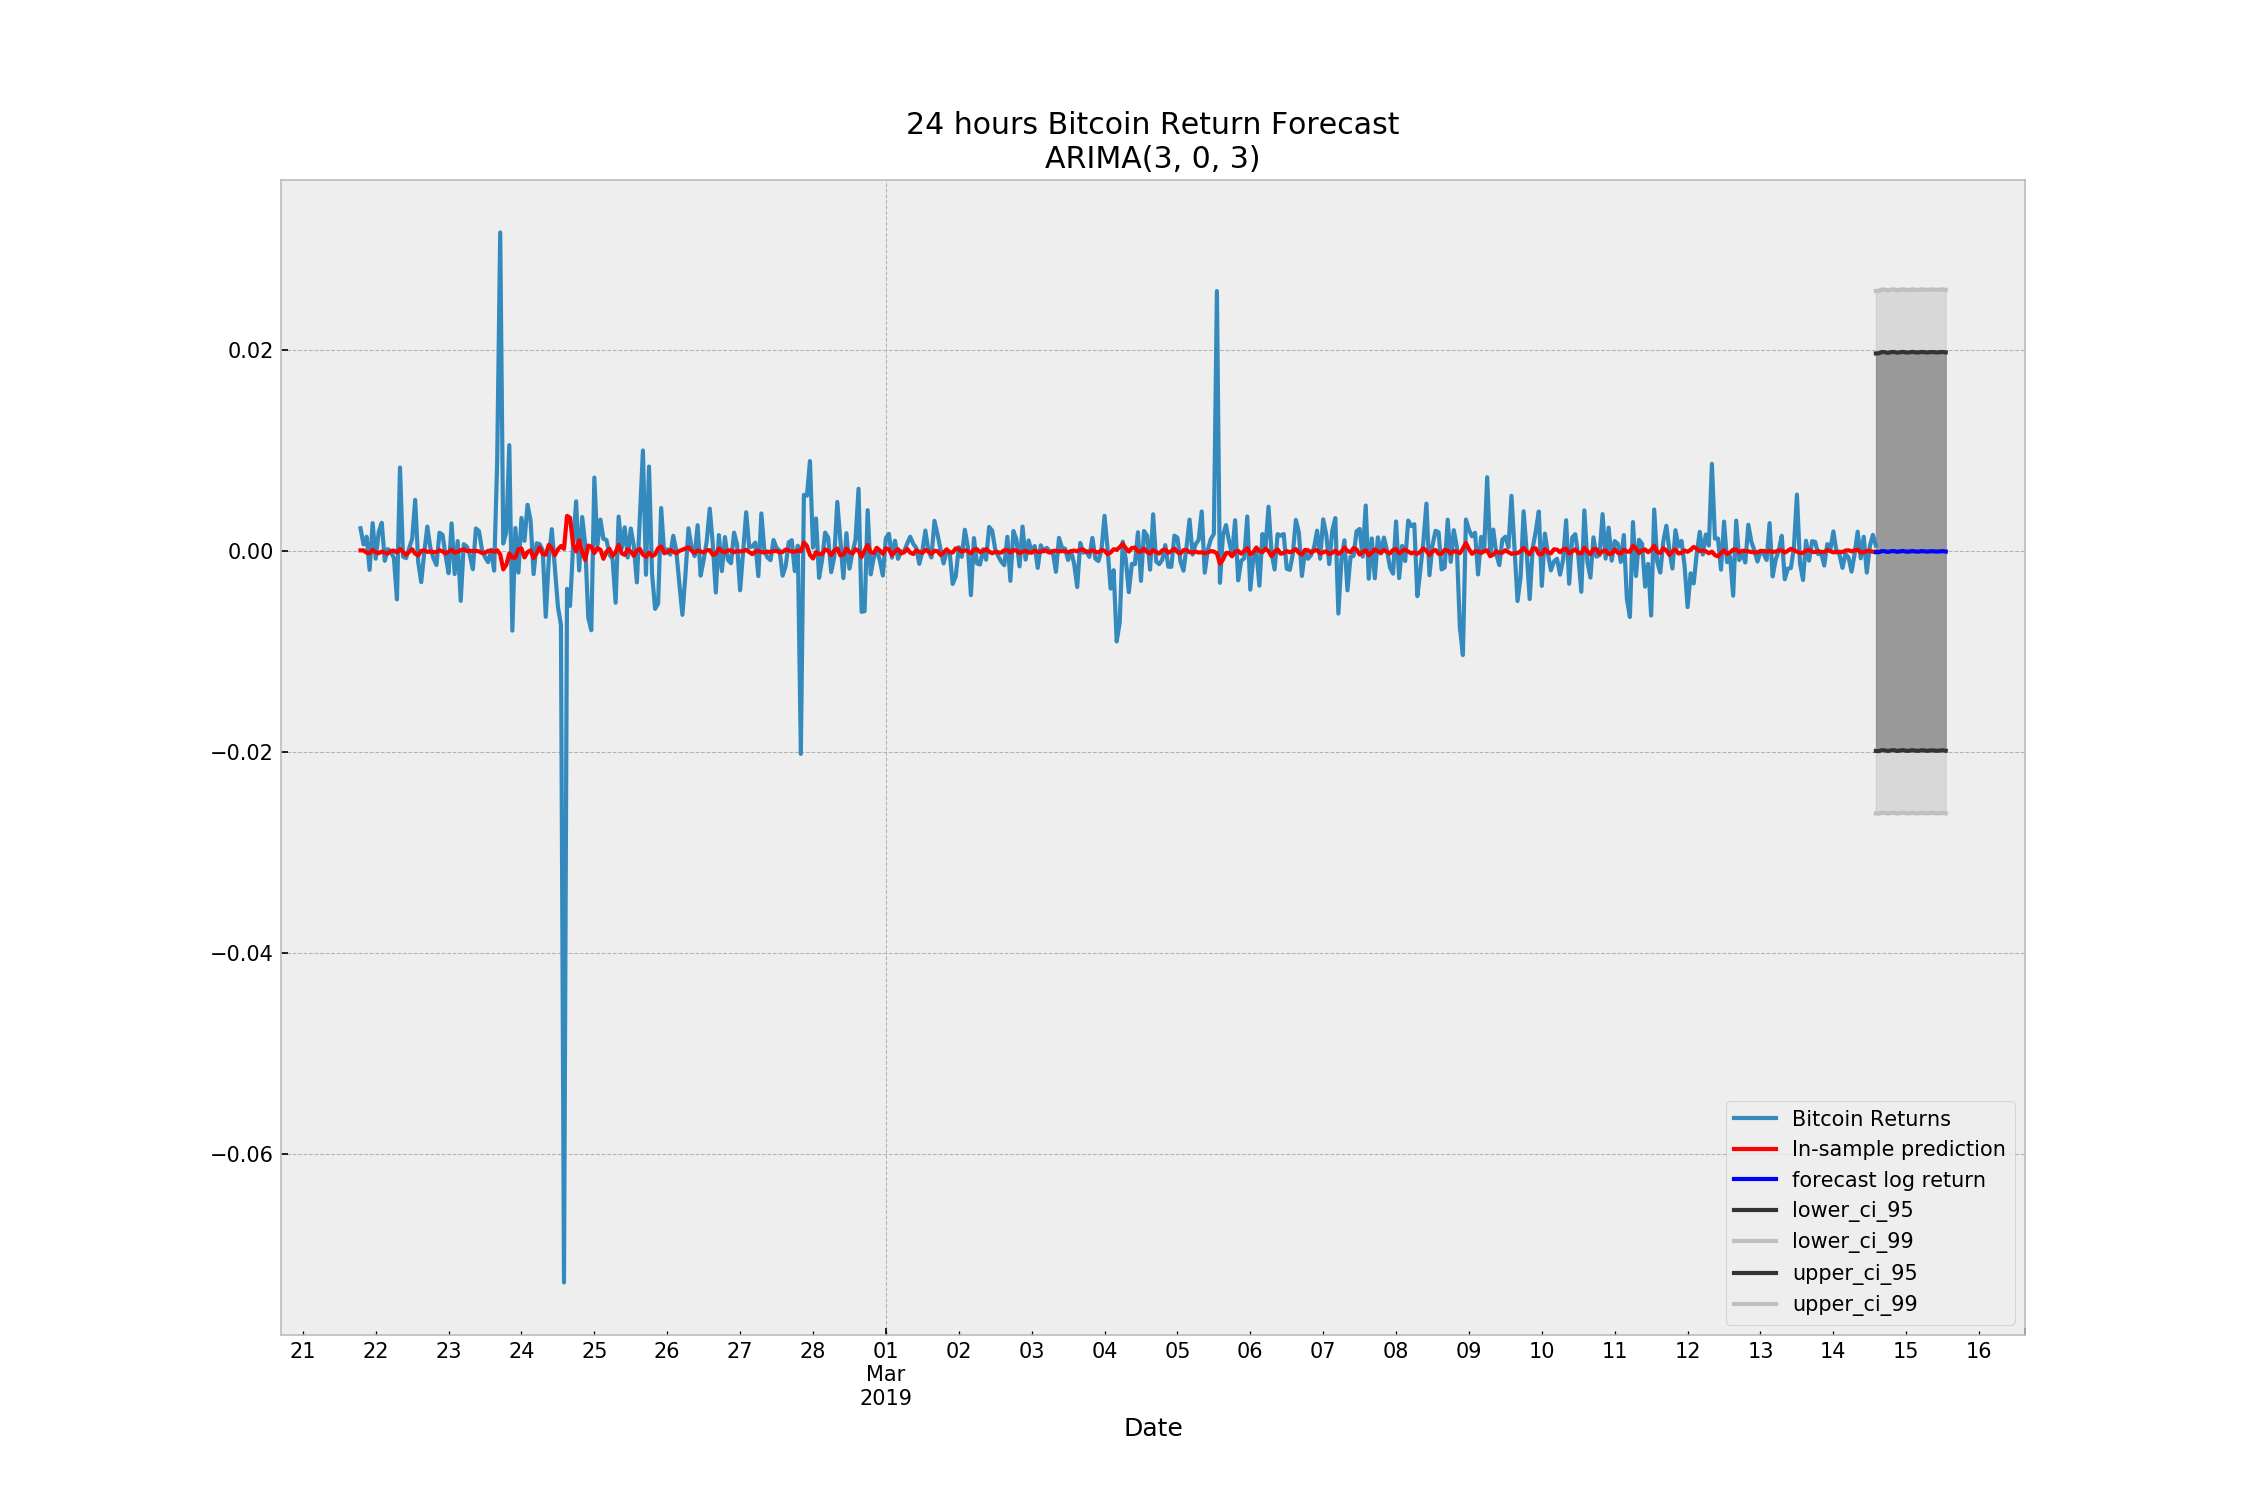

In [127]:
plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = lretsTrain['Close'].iloc[-500:].copy()
ts.plot(ax=ax, label='Bitcoin Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} hours Bitcoin Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

### plot the price in the next six hours

In [132]:
fc_all['Actual Price'] = testset['Close']
fc_all

,forecast log return,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99,Actual Price
2019-03-14 14:00:00,-0.000077,-0.019852,-0.026066,0.019697,0.025911,3852.22
2019-03-14 15:00:00,-0.000078,-0.019873,-0.026092,0.019716,0.025936,3855.95
2019-03-14 16:00:00,0.000034,-0.019774,-0.025998,0.019842,0.026066,3849.07
2019-03-14 17:00:00,0.000007,-0.019801,-0.026025,0.019815,0.026039,3856.90
2019-03-14 18:00:00,-0.000055,-0.019863,-0.026087,0.019753,0.025978,3851.74
2019-03-14 19:00:00,0.000023,-0.019788,-0.026013,0.019833,0.026058,3850.97
2019-03-14 20:00:00,0.000031,-0.019780,-0.026005,0.019841,0.026066,3852.00
2019-03-14 21:00:00,-0.000044,-0.019856,-0.026081,0.019768,0.025993,3856.74
2019-03-14 22:00:00,0.000001,-0.019811,-0.026037,0.019814,0.026039,3854.92
2019-03-14 23:00:00,0.000039,-0.019774,-0.025999,0.019852,0.026078,3855.87


Save the result to CSV file

In [85]:
fc_all.to_csv('forcecast_bitcoin.csv', index = None, header=True)